# Make a simple pujol test example

In [13]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np

In [3]:
import galsim

In [29]:
stamp_size = 51
batch_size = 1
shear_true = [0.,0.]
true_epsf = [0.,0.]
noise_level = 1e-3
gal_hlr = 0.5
flux = 1.
scale = 0.263
psf_fwhm = 0.7
method = 'auto'

In [30]:
psf_obj = galsim.Moffat(beta=4.8, fwhm=psf_fwhm).shear(g1=true_epsf[0],g2=true_epsf[1])

In [31]:
noise_imgs = np.random.normal(scale=noise_level,size=[batch_size,stamp_size,stamp_size])

In [32]:
intrinsic_shape = [0,0]
obj = galsim.Exponential(half_light_radius=gal_hlr).shear(g1=intrinsic_shape[0],g2=intrinsic_shape[1])

obj = obj.shear(g1=shear_true[0] ,g2=shear_true[1] )
#convolve
obj = galsim.Convolve([obj,psf_obj])
#draw
gal_image = obj.drawImage(nx=stamp_size, ny=stamp_size, scale=scale,method=method).array
psf_image = psf_obj.drawImage(nx=stamp_size, ny=stamp_size, scale=scale,method=method).array



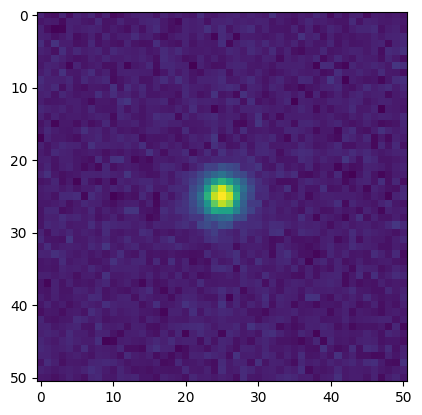

In [33]:
gal_image += noise_imgs[0]
imshow(gal_image)

In [ ]:
galsimrot90 = galsim.Angle(90,galsim.AngleUnit(np.pi/180.))

def make_noise(noise_level,batch_size,stamp_size):
  '''make a simple gaussian noise stamp'''
  noise_imgs = np.random.normal(scale=noise_level,size=[batch_size,stamp_size,stamp_size])
  return noise_imgs

def observer(batch_size=25, 
             shear_true = [0.,0.] ,
             true_epsf = [0.,0.], 
             noise_level = 1e-6,
             shape_noise = False,
             symmetric = True):
  '''creates observations for ngmix and amc'''
  #galaxy intrinsic properties
  gal_hlr = 0.5
  flux = 1.
  psf_fwhm =
  
  #psf properties
  psf_obj = galsim.Moffat(beta=4.8, fwhm=psf_fwhm).shear(g1=true_epsf[0],g2=true_epsf[1]) 
  psf_images_list = []
  gal_images_list = []
  method ='auto'
  for i in range(batch_size):
    #intrinsic shape
    intrinsic_shape = [0,0] #for the future, add shape noise
    
    obj = galsim.Exponential(half_light_radius=gal_hlr).shear(g1=intrinsic_shape[0],g2=intrinsic_shape[1])
    #shear
    obj = obj.shear(g1=shear_true[0] ,g2=shear_true[1] )
    #convolve
    obj = galsim.Convolve([obj,psf_obj])
    #draw
    gal_image = obj.drawImage(nx=stamp_size, ny=stamp_size, scale=scale,method=method).array
    psf_image = psf_obj.drawImage(nx=stamp_size, ny=stamp_size, scale=scale,method=method).array
    
    psf_images_list += [psf_image]
    gal_images_list += [gal_image]
  
  psf_images = tf.convert_to_tensor(np.array(psf_images_list),dtype=tf.float32)
  gal_images = tf.convert_to_tensor(np.array(gal_images_list),dtype=tf.float32)
  
  #add noise
  noise_images = make_noise(noise_level,batch_size,stamp_size)
  gal_images += noise_images
  
  #add noise to the psf model after convolution to make it an observed model
  psf_noise_images = make_noise(psf_noise_level,batch_size,stamp_size)
  psf_images += psf_noise_images
    
  #images to be used for fixnoise are different from the
  #actual noise, but with the same level
  noise_images_out = make_noise(noise_level,batch_size,stamp_size)
  
  if symmetric:
    
    psf_images90_list = []
    gal_images90_list = []
    for i in range(batch_size):
      #intrinsic shape
      intrinsic_shape = [0,0] #for the future, add shape noise
      
      obj90 = galsim.Exponential(half_light_radius=gal_hlr).shear(g1=intrinsic_shape[0],g2=intrinsic_shape[1]).rotate(galsimrot90)
      #shear
      obj90 = obj90.shear(g1=shear_true[0] ,g2=shear_true[1])
      #convolve
      obj90 = galsim.Convolve([obj90,psf_obj])
      #draw
      gal_image90 = obj90.drawImage(nx=stamp_size, ny=stamp_size, scale=scale,method=method).array
      psf_image90 = psf_obj.drawImage(nx=stamp_size, ny=stamp_size, scale=scale,method=method).array

      psf_images90_list += [psf_image90]
      gal_images90_list += [gal_image90]

    psf_images90 = tf.convert_to_tensor(np.array(psf_images90_list),dtype=tf.float32)
    gal_images90 = tf.convert_to_tensor(np.array(gal_images90_list),dtype=tf.float32)
   
    #add noise
    noise_images90 = make_noise(noise_level,batch_size,stamp_size)
    gal_images90 += noise_images90
    
    #add noise to the psf model
    psf_noise_images90 = make_noise(psf_noise_level,batch_size,stamp_size)
    psf_images90 += psf_noise_images90
    
    #images to be used for fixnoise are different from the
    #actual noise, but with the same level
    noise_images_out90 = make_noise(noise_level,batch_size,stamp_size)
    
    #concatenate symmetrised obs
    gal_images= np.concatenate([gal_images,gal_images90])
    psf_images = np.concatenate([psf_images,psf_images90])
    noise_images_out = np.concatenate([noise_images_out,noise_images_out90])
  
  #generate observations for ngmix
  obslist = []
  for im, psf_im in zip(gal_images,psf_images):
    cen = (np.array(im.shape))//2
    psf_cen = (np.array(psf_im.shape))//2

    jacobian = ngmix.DiagonalJacobian(
        row=cen[0], col=cen[1], scale=scale,
    )
    psf_jacobian = ngmix.DiagonalJacobian(
        row=psf_cen[0], col=psf_cen[1], scale=scale,
    )
    wt = im*0 + 1.0/noise_level**2
    psf_wt = psf_im*0 + 1.0/psf_noise_level**2

    psf_obs = ngmix.Observation(
        psf_im,
        weight=psf_wt,
        jacobian=psf_jacobian,
    )

    obs = ngmix.Observation(
        im,
        weight=wt,
        jacobian=jacobian,
        psf=psf_obs,
    )
    obslist += [obs]
  
  return gal_images, psf_images ,noise_images_out, obslist